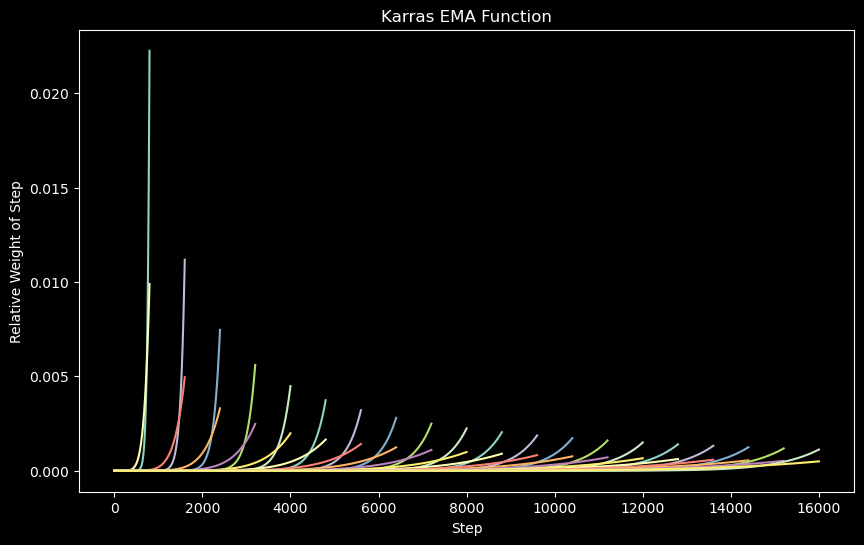

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.backends.cudnn.benchmark=True
torch.use_deterministic_algorithms(True)
GAMMA_HI = 16.97
GAMMA_LO = 6.94
TOTAL_STEPS = 16000
CHECKPOINT_EVERY = 800

NUM_CHECKPOINTS = TOTAL_STEPS/CHECKPOINT_EVERY
GAMMA_LIST = [GAMMA_HI, GAMMA_LO]
# Generate checkpoint steps
CHECKPOINT_LIST = np.arange(1, NUM_CHECKPOINTS+1) * CHECKPOINT_EVERY

def beta_gamma(gamma, step):
    return (1 - 1/step) ** (gamma + 1)

def ema_simulation(step_weights):
    output = (1 - step_weights)
    for t, wt in enumerate(step_weights):
        output[:t] *= (wt)
    return output

# Plot the beta_gamma function for each gamma value
plt.figure(figsize=(10, 6))
ema_model_list = []
for checkpoint in CHECKPOINT_LIST:
    for gamma in GAMMA_LIST:
        steps = np.arange(1, checkpoint)
        values = ema_simulation(beta_gamma(gamma, steps))
        ema_model_list.append(values)
        plt.plot(steps, values, label=f'Gamma = {gamma}, checkpoint = {checkpoint}')

plt.title('Karras EMA Function')
plt.xlabel('Step')
plt.ylabel('Relative Weight of Step')
plt.show()

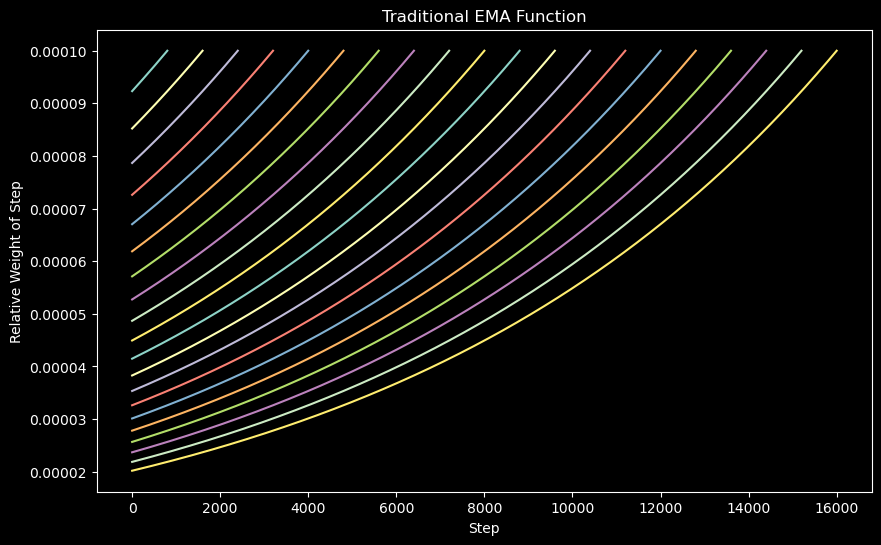

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot a simulation of traditional EMA for comparison.
plt.figure(figsize=(10, 6))
for checkpoint in CHECKPOINT_LIST:
    steps = np.arange(1, checkpoint+1)
    weights = np.full((int(checkpoint)), 0.9999)
    values = ema_simulation(weights)
    plt.plot(steps, values, label=f'Decay = {0.9999}, checkpoint = {checkpoint}')

plt.title('Traditional EMA Function')
plt.xlabel('Step')
plt.ylabel('Relative Weight of Step')
plt.show()

In [15]:
def sigma_rel_to_gamma(sigma_rel):
    t = sigma_rel ** -2
    gamma = np.roots([1, 7, 16 - t, 12 - t]).real.max()
    return gamma

def p_dot_p(t_a, gamma_a, t_b, gamma_b):
    t_ratio = t_a / t_b
    t_exp = np.where(t_a < t_b, gamma_b, -gamma_a)
    t_max = np.maximum(t_a, t_b)
    num = (gamma_a + 1) * (gamma_b + 1) * t_ratio ** t_exp
    den = (gamma_a + gamma_b + 1) * t_max
    return num / den

def solve_weights(t_i, gamma_i, t_r, gamma_r):
    rv = lambda x: np.float128(x).reshape(-1, 1)
    cv = lambda x: np.float128(x).reshape(1, -1)
    a = p_dot_p(rv(t_i), rv(gamma_i), cv(t_i), cv(gamma_i))
    b = p_dot_p(rv(t_i), rv(gamma_i), cv(t_r), cv(gamma_r))
    x = np.linalg.solve(np.float64(a), np.float64(b))
    return x

checkpoints = np.array(CHECKPOINT_LIST).repeat(len(GAMMA_LIST))
gammas = np.tile(np.array(GAMMA_LIST), len(CHECKPOINT_LIST))
hilo = np.tile(np.array(['hi', 'lo']), len(CHECKPOINT_LIST))
# Test one weight profile to make sure it works and to demonstrate the output format
print(gammas)
print(checkpoints)
print(hilo)
target_t = np.array(TOTAL_STEPS)
target_gamma = np.array(sigma_rel_to_gamma(0.05))
print(target_gamma)
weight_profile = solve_weights(checkpoints, np.array(gammas), target_t, np.array(target_gamma)).squeeze()
print(weight_profile)
print(weight_profile.sum())

[ 16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94
  16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94
  16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94
  16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94  16.97   6.94]
[   800.    800.   1600.   1600.   2400.   2400.   3200.   3200.   4000.
   4000.   4800.   4800.   5600.   5600.   6400.   6400.   7200.   7200.
   8000.   8000.   8800.   8800.   9600.   9600.  10400.  10400.  11200.
  11200.  12000.  12000.  12800.  12800.  13600.  13600.  14400.  14400.
  15200.  15200.  16000.  16000.]
['hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi'
 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo'
 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo' 'hi' 'lo']
16.972198602303443
[ -6.32827969e-27   9.16520366e-25  -9.52789885e-22   1.31060838e-20
  -9.96075025e-19   5.94055503e-18  -1.37263321e-16   5.58184912e-16
  -6.22590599e-15   2.074137

63.6589342317
36.9868397124
16.9721986023
6.9372039376
3.5578687749
1.8262137799
0.719823958001


/tmp/ipykernel_715287/1955797102.py:17: RuntimeWarning: divide by zero encountered in divide
  return (1 - 1/step) ** (gamma + 1)
/tmp/ipykernel_715287/1955797102.py:22: RuntimeWarning: invalid value encountered in multiply
  output[:t] *= (wt)


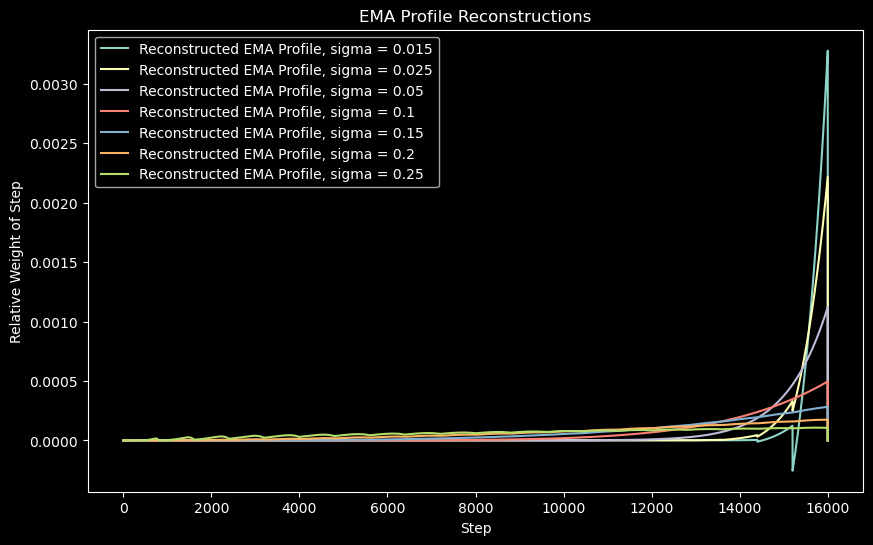

In [16]:
SIGMA_LIST = [0.015, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25]
for sigma in SIGMA_LIST:
    print(sigma_rel_to_gamma(sigma))
target_t = np.array(TOTAL_STEPS)
plt.figure(figsize=(10, 6))
for sigma in SIGMA_LIST:
    target_gamma = np.array(sigma_rel_to_gamma(sigma))
    weight_profile = solve_weights(checkpoints, np.array(gammas), target_t, np.array(target_gamma)).squeeze()

    final_weights = np.zeros((TOTAL_STEPS))
    for idx, weight in enumerate(weight_profile):
        model = ema_model_list[idx]
        final_weights[:model.shape[0]] += (model * weight)

    plt.plot(np.arange(0, TOTAL_STEPS), final_weights, label=f'Reconstructed EMA Profile, sigma = {sigma}')

for sigma in SIGMA_LIST:
    steps = np.arange(0, TOTAL_STEPS)
    values = ema_simulation(beta_gamma(sigma_rel_to_gamma(sigma), steps))
    ema_model_list.append(values)
    # plt.plot(steps, values, label=f'Real EMA, sigma = {sigma}')

plt.title('EMA Profile Reconstructions')
plt.xlabel('Step')
plt.legend()
plt.ylabel('Relative Weight of Step')
plt.show()

In [17]:
import torch
def target_to_checkpoint_path_st(gamma, steps):
    return f"./checkpoints/convnextv2_nano_srgb-ema2_tune/{int(steps)}_net_ema_{gamma}.pth"


def remove_module_prefix(state_dict):
    # Remove "module." prefix from keys
    new_state_dict = {key.replace('module.', ''): value for key, value in state_dict.items()}
    return new_state_dict


model_mmap_list = []
for i in range(len(hilo)):
    path = target_to_checkpoint_path_st(hilo[i], checkpoints[i])

    # Load the state dictionary with memory mapping and fix the keys
    model_state_dict = torch.load(path, map_location=lambda storage, loc: storage, mmap=True)
    model_state_dict = remove_module_prefix(model_state_dict)

    model_mmap_list.append(model_state_dict)

In [19]:
# CURRENT RECORD: nano-srgb-ema, 16000, sigma=0.1,  70.93% acc
# CURRENT RECORD: nano-srgb-ema2, 16000, sigma=0.05,  71.043% acc

from tqdm.notebook import tqdm
import lpips
from safetensors.torch import save_file
from data import data_loader as dl
import random
# sigma_list = [0.015, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25]
sigma_list = [0.05]
ema_model = lpips.LPIPS(
    pretrained=True,
    net='convnextv2_nano',
    model_path="./checkpoints/convnextv2_nano_srgb-ema2_tune/latest_net_.pth"
)

for sigma in sigma_list:

    target_gamma = np.array(sigma_rel_to_gamma(sigma))
    weight_profile = solve_weights(checkpoints, np.array(gammas), target_t, np.array(target_gamma)).squeeze()

    weight_dict = {}
    for key in tqdm(ema_model.state_dict().keys(), desc=f"Synthesizing EMA profile, σ={sigma}"):
        stacked_weights = torch.stack([state_dict[key] for state_dict in model_mmap_list]).double()

        wp_unsqueezed = torch.tensor(weight_profile, dtype=torch.float64)
        for _ in range(stacked_weights.dim() - 1):
            wp_unsqueezed = wp_unsqueezed.unsqueeze(-1)
        scaled_weights = stacked_weights * wp_unsqueezed
        weight_dict[key] = torch.sum(scaled_weights[torch.argsort(torch.abs(torch.tensor(weight_profile, dtype=torch.float64)))], dim=0)

    ema_model.load_state_dict(weight_dict)
    ema_model.cuda()
    print(f"VALIDATION FOR SIGMA={sigma}:")
    val_distortions = 0.0
    val_algorithms = 0.0
    val_all = 0.0
    for val_dataset in ['val/traditional','val/cnn','val/superres','val/deblur','val/color','val/frameinterp']:
        torch.manual_seed(42)
        np.random.seed(42)
        random.seed(42)
        val_data_loader = dl.CreateDataLoader(val_dataset,dataset_mode='2afc', load_size=64, batch_size=50, nThreads=12, colorspace='srgb')
        with torch.no_grad():
            # evaluate model on data
            (score, results_verbose) = lpips.score_2afc_dataset(val_data_loader, ema_model.forward, name=val_dataset)

        val_all += score / 6
        if val_dataset == 'val/traditional' or val_dataset == 'val/cnn':
            val_distortions += score / 2
        else:
            val_algorithms += score / 4
        # print results
        print('  Dataset [%s]: %.3f'%(val_dataset,100.*score))

    print('  Average [%s]: %.3f'%('distortions',100.*val_distortions))
    print('  Average [%s]: %.3f'%('algorithms',100.*val_algorithms))
    print('  Average [%s]: %.3f'%('overall',100.*val_all))
    ema_model.cpu()

torch.save(ema_model.state_dict(), "./LPIPS-sRGB-ConvNextV2-N-EMA.pth")
save_file(ema_model.state_dict(), "./LPIPS-sRGB-ConvNextV2-N-EMA.safetensors")

Setting up [LPIPS] perceptual loss: trunk [convnextv2_nano], v[0.1], spatial [off]
Loading model from: ./checkpoints/convnextv2_nano_srgb-ema2_tune/latest_net_.pth


Synthesizing EMA profile, σ=0.05:   0%|          | 0/162 [00:00<?, ?it/s]

VALIDATION FOR SIGMA=0.05:


  Dataset [val/traditional]: 80.051


  Dataset [val/cnn]: 84.428


  Dataset [val/superres]: 71.716


  Dataset [val/deblur]: 61.485


  Dataset [val/color]: 65.323


  Dataset [val/frameinterp]: 63.254
  Average [distortions]: 82.239
  Average [algorithms]: 65.445
  Average [overall]: 71.043
